In [1]:
import os
import gc
import re
import urllib.request

# import cartopy.crs as ccrs
# import matplotlib.pyplot as plt
import numpy as np
# from rasterio.warp import transform
import pandas as pd
import xarray as xr
import xesmf as xe

# from dask.diagnostics import ProgressBar
# from distributed import Client
from xesmf.backend import (esmf_grid, esmf_regrid_build,
                           esmf_regrid_apply, esmf_regrid_finalize)
from xesmf.smm import read_weights, apply_weights

In [2]:
# client = Client(n_workers=12)
# client

In [3]:
ref = xr.open_dataset("../../../data_general/proc_sif-optim/covar_nc/sif_refgrid.nc")
ref = ref['SIF']
lon, lat = ref.indexes.values()
lat.min(axis=0)

24.0

In [5]:
da = xr.open_rasterio('../../../data_general/proc_sif-optim/myd11a1_2018-0000000000-0000000000.tif')


In [39]:
ds_in = xe.util.grid_2d(-125,-60,0.25,
                -25,50,0.25)
ds_out = xe.util.grid_2d(-125,-65.00150000000001,0.045,
                         24,49.9965,0.045)

In [55]:
ds_out

<xarray.Dataset>
Dimensions:  (y: 578, x: 1334, y_b: 579, x_b: 1335)
Coordinates:
    lon      (y, x) float64 -125.0 -124.9 -124.9 -124.8 ... -65.08 -65.04 -64.99
    lat      (y, x) float64 24.02 24.02 24.02 24.02 ... 49.99 49.99 49.99 49.99
    lon_b    (y_b, x_b) float64 -125.0 -125.0 -124.9 ... -65.06 -65.01 -64.97
    lat_b    (y_b, x_b) float64 24.0 24.0 24.0 24.0 ... 50.01 50.01 50.01 50.01
Dimensions without coordinates: y, x, y_b, x_b
Data variables:
    *empty*

In [40]:
ds_in.coords['time'] = np.arange(1,11)
ds_in.coords['lev'] = np.arange(1,51)
ds_in['data_2D'] = xe.data.wave_smooth(ds_in['lon'],ds_in['lat'])
ds_in['data_4D'] = ds_in['time']*ds_in['lev']*ds_in['data_2D']
ds_in

<xarray.Dataset>
Dimensions:  (y: 300, x: 260, y_b: 301, x_b: 261, time: 10, lev: 50)
Coordinates:
    lon      (y, x) float64 -124.9 -124.6 -124.4 -124.1 ... -60.62 -60.38 -60.12
    lat      (y, x) float64 -24.88 -24.88 -24.88 -24.88 ... 49.88 49.88 49.88
    lon_b    (y_b, x_b) float64 -125.0 -124.8 -124.5 ... -60.5 -60.25 -60.0
    lat_b    (y_b, x_b) float64 -25.0 -25.0 -25.0 -25.0 ... 50.0 50.0 50.0 50.0
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10
  * lev      (lev) int64 1 2 3 4 5 6 7 8 9 10 ... 41 42 43 44 45 46 47 48 49 50
Dimensions without coordinates: y, x, y_b, x_b
Data variables:
    data_2D  (y, x) float64 1.715 1.708 1.702 1.695 ... 1.781 1.785 1.788 1.791
    data_4D  (time, lev, y, x) float64 1.715 1.708 1.702 ... 892.3 893.8 895.4

In [41]:
lon_in = ds_in['lon'].values
lat_in = ds_in['lat'].values

lon_out = ds_out['lon'].values
lat_out = ds_out['lat'].values

data_in = ds_in['data_4D'].values
data_in.shape

(10, 50, 300, 260)

In [42]:
grid_in = esmf_grid(lon_in.T, lat_in.T)
grid_out = esmf_grid(lon_out.T, lat_out.T)

In [43]:
type(grid_in)

ESMF.api.grid.Grid

In [44]:
lon_in.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

In [45]:
lon_in.T.flags

  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

In [52]:
filename = 'test_weights.nc'
if os.path.exists(filename):
    os.remove(filename)

In [53]:
%%time 
regrid = esmf_regrid_build(grid_in,grid_out,'nearest_s2d',
                           extra_dims=[50,10],
                           filename=filename)


TypeError: buffer is too small for requested array

In [48]:
type(regrid)

ESMF.api.regrid.Regrid

In [51]:
gc.collect()

23

In [44]:
data_in.shape

(10, 50, 300, 260)

In [45]:
%%bash
ncdump -h test_weights.nc

netcdf test_weights {
dimensions:
	n_s = 1239056 ;
variables:
	double S(n_s) ;
	int col(n_s) ;
	int row(n_s) ;
}


In [46]:
%%time
data_out_esmpy = esmf_regrid_apply(regrid, data_in.T).T

CPU times: user 1.15 s, sys: 400 ms, total: 1.55 s
Wall time: 1.55 s


In [47]:
data_out_esmpy.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

In [48]:
data_out_esmpy.shape

(10, 50, 600, 520)

In [49]:
da = xr.open_dataset("../../../data_general/proc_sif-optim/myd_lst/myd11a1_2018.nc")
da = da['lst']

In [50]:
da = da.rename({"x":"lon",
          "y":"lat"})
da = da.isel(time=0)
da


<xarray.DataArray 'lst' (lat: 2766, lon: 6434)>
[17796444 values with dtype=float32]
Coordinates:
    time     datetime64[ns] 2018-01-01
  * lat      (lat) float64 49.38 49.38 49.37 49.36 ... 24.57 24.56 24.56 24.55
  * lon      (lon) float64 -124.7 -124.7 -124.7 -124.7 ... -66.96 -66.96 -66.95
Attributes:
    transform:      [ 8.98315284e-03  0.00000000e+00 -1.24740060e+02  0.00000...
    crs:            +init=epsg:4326
    res:            [0.00898315 0.00898315]
    is_tiled:       1
    nodatavals:     [nan nan nan nan nan nan nan nan nan nan nan nan nan nan ...
    scales:         [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1....
    offsets:        [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....
    AREA_OR_POINT:  Area

In [62]:
ref_grid = xr.open_dataset("../../../data_general/proc_sif-optim/covar_nc/sif_refgrid.nc")['SIF']
ref_grid = ref_grid.sel(lat=slice(40,50),lon=slice(-129,-120))
ref_grid

<xarray.DataArray 'SIF' (lat: 2222, lon: 1112)>
[2470864 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -125.0 -125.0 -125.0 -125.0 ... -120.0 -120.0 -120.0
  * lat      (lat) float64 40.0 40.01 40.01 40.02 ... 49.98 49.99 49.99 50.0
Attributes:
    Unit:     mW/m^2/sr/nm

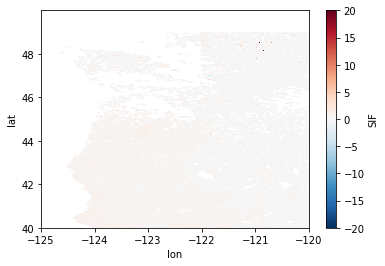

In [63]:
ref_grid.plot()

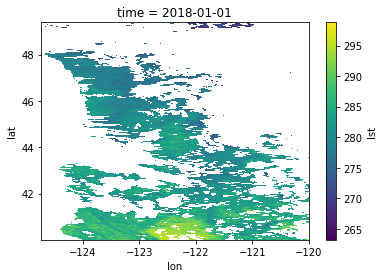

In [59]:
da = da.sel(lat=slice(50,40),lon=slice(-129,-120))
da.plot()

In [64]:
regridder = xe.Regridder(da, ref_grid, 'bilinear')
# regridder.clean_weight_file()
regridder

/home/sami/miniconda3/envs/sci/lib/python3.8/site-packages/xarray/core/dataarray.py:789: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_2766x6434_2222x1112.nc 
Reuse pre-computed weights? False 
Input grid shape:           (2766, 6434) 
Output grid shape:          (2222, 1112) 
Periodic in longitude?      False

In [ ]:
da_out = regridder(da)

In [ ]:
# Compute the lon/lat coordinates with rasterio.warp.transform
ny, nx = len(da['y']), len(da['x'])
x, y = np.meshgrid(da['x'], da['y'])

# Rasterio works with 1D arrays
lon, lat = transform(d1.crs, {'init': 'EPSG:4326'},
                     x.flatten(), y.flatten())
lon = np.asarray(lon).reshape((ny, nx))
lat = np.asarray(lat).reshape((ny, nx))
da.coords['lon'] = (('y', 'x'), lon)
da.coords['lat'] = (('y', 'x'), lat)


In [2]:
ref = xr.open_dataset("../../../data_general/proc_sif-optim/covar_nc/sif_refgrid.nc")
ref = ref['SIF']
ref

<xarray.DataArray 'SIF' (lat: 5778, lon: 13334)>
[77043852 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -125.0 -125.0 -125.0 -125.0 ... -65.01 -65.01 -65.0
  * lat      (lat) float64 24.0 24.0 24.01 24.01 ... 49.98 49.99 49.99 50.0
Attributes:
    Unit:     mW/m^2/sr/nm

In [54]:
%%bash 
ls

dask-worker-space
import_lst.ipynb
import_ssma.ipynb
merge_lst_to_nc.ipynb
PET0.ESMF_LogFile
regrid_lst.ipynb
regrid_lst.py
setup_env.sh
Untitled1.ipynb
Untitled.ipynb
xesmf_regrid.ipynb
